# 数据挖掘大作业 - 北京市二手房房价预测
项目地址: https://github.com/tenkeyseven/DataMining_Price_Prediction

## 小组成员
+ 周慧鹏(3220201027):数据爬取分析和分析处理、算法分析和实现、文档编写 
+ 刘欣睿(3220200923):数据可视化、算法分析和实现、文档编写 
+ 罗楠(3220200932):数据爬取分析和分析处理、算法分析和实现、文档编写 
+ 刘雨程(3220200926):数据可视化、算法分析和实现、文档编写 
+ 康子健(3120201034):数据爬取分析和分析处理、算法分析和实现、文档编写

## 问题背景以及分析

房价是人⺠群众及其关注的热点以及重点问题，房价的走势关系着人⺠的生活以及社会的发展。因此，
本小组从此出发点切入，利用数据挖掘相关技术和思想，对历年来北京市二手房房价进行搜集、分析和
处理，利用相关算法对整理后的数据进行仔细分析和研究。最后，形成对北京市二手房数据的分析、可
视化展示、以及利用相关算法(例如，将房价预测价格问题作为回归任务)对未来房价进行预测。

## 本项目结构

包括了：
+ 数据分析与可视化部分
+ 房价预测-链家数据读取
+ 抽取相关特征
+ 对房价数据进行预测
    + 使用线性回归方法
    + 使用决策树方法

## 其他

### 本项目使用以下库以及对应的版本
```bash
python == 3.8
numpy == 1.19.2 
pandas == 1.2.3
sklearn  == 0.2.4

```

## 1 数据分析可视化部分

定义针对数据可视化部分的相关处理函数

In [1]:
import pandas as pd

def Room(house):
    i = house.find('室')
    j = house.find('厅')
    room = house[0:i]
    if room != '--':
        return int(room)
    else:
        return -1

def LivingRoom(house):
    i = house.find('室')
    j = house.find('厅')
    living = house[i + 1:j]
    if living != '--':
        return int(living)
    else:
        return -1

def square(mianji):
    s = mianji[0:mianji.find('平')]
    if s == '0':
        return -1
    elif s != '--':
        return int(s)
    else:
        return -1

def CJdanjia(cjdanjia):
    s = cjdanjia[0:cjdanjia.find('元')]
    if int(s) <= 9999:
        return -1
    else:
        return int(s)

def Comp(line, xiaoqu, mendian,attribute):
    room = line['room']
    living = line['living']
    mianji = line['mianji']
    danjia = line['danjia']
    xiaoqu_name = line['xiaoqu']
    mendian_name = line['mendian']

    xiaoqu_set = xiaoqu.get_group(xiaoqu_name).reset_index(drop=True)
    mendian_set = mendian.get_group(mendian_name).reset_index(drop=True)

    xiaoqu_mean = round(xiaoqu_set[attribute].mean())
    mendian_mean = round(mendian_set[attribute].mean())

    xiaoqu_set = xiaoqu_set.drop(xiaoqu_set[xiaoqu_set[attribute] == -1].index).reset_index(drop=True)
    mendian_set = mendian_set.drop(mendian_set[mendian_set[attribute] == -1].index).reset_index(drop=True)

    distance_xiaoqu = abs((xiaoqu_set['room'] - room) * 20) + abs((xiaoqu_set['living'] - living) * 20) +  \
               abs(xiaoqu_set['mianji'] - mianji) + abs(xiaoqu_set['danjia'] - danjia)

    distance_mendian = abs((mendian_set['room'] - room) * 20) + abs((mendian_set['living'] - living) * 20) +  \
               abs(mendian_set['mianji'] - mianji) + abs(mendian_set['danjia'] - danjia)

    if distance_xiaoqu.empty and distance_mendian.empty:
        if xiaoqu_set.__len__() < 2:
            return mendian_mean
        else:
            return xiaoqu_mean
    elif ~distance_xiaoqu.empty and ~distance_mendian.empty:
        if distance_xiaoqu.min()<distance_mendian.min():
            index = distance_xiaoqu.idxmin()
            return xiaoqu_set.iloc[index][attribute]
        else:
            index = distance_mendian.idxmin()
            return mendian_set.iloc[index][attribute]
    elif ~distance_xiaoqu.empty and distance_mendian.empty:
        index = distance_mendian.idxmin()
        return mendian_set.iloc[index][attribute]
    else:
        index = distance_xiaoqu.idxmin()
        return xiaoqu_set.iloc[index][attribute]


In [2]:
from tqdm import tqdm
pd.set_option('mode.chained_assignment', None)
for i in [1]:
    try:
        f=open(r'./data/lianjia{}.csv'.format(i),encoding='gbk')
        data=pd.read_csv(f)
    except:
        f=open(r'./data/lianjia{}.csv'.format(i),encoding='utf-8')
        data=pd.read_csv(f)

    # data = pd.read_csv('./data/lianjia.csv',encoding='gbk')
    data['xiaoqu'],data['huxing'],data['mianji']=data['cjxiaoqu'].str.split(' ').str
    data['room'] = data['huxing'].map(Room).fillna(-1)
    data['living'] = data['huxing'].map(LivingRoom).fillna(-1)
    data['mianji'] = data['mianji'].map(square).fillna(-1)
    data['danjia'] = data['cjdanjia'].map(CJdanjia).fillna(-1)
    xiaoqu_mean = data.groupby('xiaoqu')['mianji'].mean().astype(int)
    mendian_mean = data.groupby('mendian')['mianji'].mean().astype(int)
    mendian = data.groupby('mendian')
    xiaoqu = data.groupby('xiaoqu')

    for j in range(0,data.__len__()):
    #i = 243
        line = data.iloc[j]

        if line['room'] == -1:
            line['room'] = Comp(line,xiaoqu,mendian,'room')

        if line['living'] == -1:
            line['living'] = Comp(line, xiaoqu, mendian,'living')

        if line['mianji'] <= 0:
            line['mianji'] = Comp(line, xiaoqu, mendian,'mianji')

        if line['danjia'] <= 0:
            line['danjia'] = Comp(line, xiaoqu, mendian,'danjia')
            line['cjzongjia'] = line['mianji'] * line['danjia'] / 10000

        data.iloc[j] = line

    data['room'] = data['room'].astype(str)
    data['living'] = data['living'].astype(str)
    data['mianji'] = data['mianji'].astype(str)
    data['danjia'] = data['danjia'].astype(str)
    data['danjia'] = data['danjia']+'元/平'

    data['new'] = data['xiaoqu']+' '+data['room']+'室'+data['living']+'厅'+' '+data['mianji']+'平'

    data.drop(['huxing','room','mianji','cjdanjia','living','cjxiaoqu'], axis=1)
    data.to_csv('./processed_data/lianjia{}.csv'.format(i),encoding='gbk',columns=['cjtaoshu','mendian','cjzongjia','zhiwei','haoping','danjia',
                                                    'new','xingming','cjzhouqi','biaoqian','cjlouceng','cjshijian',
                                                    'congyenianxian','bankuai'])


<ipython-input-2-823138197188>:12: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  data['xiaoqu'],data['huxing'],data['mianji']=data['cjxiaoqu'].str.split(' ').str


In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import tqdm
import numpy as np
from sklearn.linear_model import LinearRegression
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')
# Windows 下正常字体
# plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
# macOS 下正常字体
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']

In [4]:
print('加载数据集')
data = pd.read_csv('processed_data/lianjia1.csv', index_col=0,encoding='gbk')
print('属性类别数:', len(data.columns))
print('总行数:', len(data))
print('示例数据:')
data.head(5)

加载数据集
属性类别数: 14
总行数: 1556
示例数据:


cjtaoshu mendian  cjzongjia zhiwei  haoping    danjia              new  \
0        37   红莲北里店      251.0    店经理  97% 141  43997元/平    红莲北里 3室1厅 57平   
1        37   红莲北里店      159.0    店经理  97% 141  36969元/平    红莲南里 1室1厅 43平   
2        37   红莲北里店      257.0    店经理  97% 141  39046元/平   常青藤嘉园 1室1厅 65平   
3        37   红莲北里店      243.0    店经理  97% 141  41313元/平    红莲北里 2室1厅 58平   
4        37   红莲北里店      372.5    店经理  97% 141  42053元/平  广安门外大街 3室1厅 88平   

  xingming  cjzhouqi        biaoqian        cjlouceng        cjshijian  \
0      郭海龙        36  房东信赖;销售达人;带看活跃       南 北/高楼层/6层  签约时间：2015-05-24   
1      郭海龙        36  房东信赖;销售达人;带看活跃         南/高楼层/7层  签约时间：2015-05-10   
2      郭海龙        36  房东信赖;销售达人;带看活跃        北/低楼层/16层  签约时间：2015-04-26   
3      郭海龙        36  房东信赖;销售达人;带看活跃       南 北/高楼层/6层  签约时间：2015-04-04   
4      郭海龙        36  房东信赖;销售达人;带看活跃  东 南 西 北/中楼层/18层  签约时间：2015-04-01   

  congyenianxian bankuai  
0           4-5年     马连道  
1           4-5年     马连道  
2           4-5年     马连道  
3           4-5年     马连道  
4           4-5年     马连道

In [5]:
print('提取每一列属性以及名称')
num_fields = data.select_dtypes(include=np.number).columns.values
nom_fields = data.select_dtypes(exclude=np.number).columns.values
print('标称属性:', nom_fields)
print('数值属性:', num_fields)
print(data.shape," ",nom_fields.shape," ",num_fields.shape)

提取每一列属性以及名称
标称属性: ['mendian' 'zhiwei' 'haoping' 'danjia' 'new' 'xingming' 'biaoqian'
 'cjlouceng' 'cjshijian' 'congyenianxian' 'bankuai']
数值属性: ['cjtaoshu' 'cjzongjia' 'cjzhouqi']
(1556, 14)   (11,)   (3,)


In [6]:
print("统计每一个属性的个数")
print('\nmendian(门店):')
a=data['mendian'].value_counts()
print(a)

print('\nzhiwei(职位):')
b=data['zhiwei'].value_counts()
print(b)

print('\nhaoping(好评):')
c=data['haoping'].value_counts()
print(c)

print('\ndanjia(成交单价):')
d=data['danjia'].value_counts()
print(d)

print('\nnew(成交单价):')
d1=data['new'].value_counts()
print(d1)

print('\nxingming(姓名):')
e=data['xingming'].value_counts()
print(e)

print('\nbiaoqian(标签):')
f=data['biaoqian'].value_counts()
print(f)

print('\ncjlouceng(成交楼层):')
g=data['cjlouceng'].value_counts()
print(g)

print('\ncjshijian(成交时间):')
h=data['cjshijian'].value_counts()
print(h)

print('\ncongyenianxian(从月年限):')
i=data['congyenianxian'].value_counts()
print(i)

print('\nbankuai(板块):')
j=data['bankuai'].value_counts()
print(j)

统计每一个属性的个数

mendian(门店):
老山旗舰店        78
皂君东里店        51
光彩路一店        50
苹果店          45
永乐店          45
马坡店          40
富力又一城四临时店    40
团结湖店         40
东风北桥店        40
月华轩店         40
阳光花园店        40
华清嘉园新店       40
日坛国际店        40
新建欣苑店        40
太东店          40
苹果园大街店       40
二里庄南店        40
南方庄店         40
新武夷花园店       40
乐成豪丽店        40
首开常青藤店       40
白家庄小学店       40
融景城店         40
莲香园店         40
安德路店         40
新城中心店        38
华尔街店         37
龙跃店          37
银河大街店        37
红莲北里店        37
裕民路店         36
朝内小街店        35
逸成东苑店        35
马连道中里店       34
定慧福里店        34
新街口西里一区店     33
金尚嘉园店        26
龙泽城铁店        26
志新店          24
交东小区店        18
Name: mendian, dtype: int64

zhiwei(职位):
店经理    1385
经纪人     171
Name: zhiwei, dtype: int64

haoping(好评):
94% 281     82
95% 414     78
97% 220     51
95% 218     50
91% 211     45
92% 168     40
92% 193     40
98% 183     40
94% 204     40
99% 124     40
93% 117     40
98% 137     40
96% 255     40
86% 142     40
95% 253     40
94% 

In [7]:
data.describe()

cjtaoshu    cjzongjia     cjzhouqi
count  1556.000000  1556.000000  1556.000000
mean     54.829049   329.726904    47.701157
std      23.388382   188.080727    13.805261
min      18.000000    14.118000    19.000000
25%      37.000000   201.375000    40.000000
50%      48.000000   283.000000    45.000000
75%      65.750000   405.000000    55.000000
max     118.000000  1560.000000    80.000000

数据可视化：

数据太多导致显示数据出现重叠看不清具体值，所以取前20个为例:
cjzongjia前20个样例:


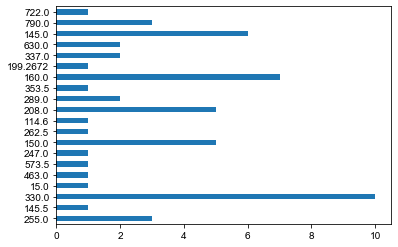

cjzhouqi前20个样例:


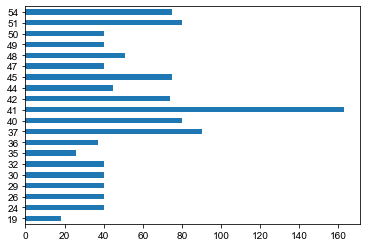

danjia前20个样例:


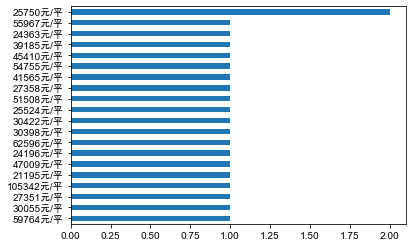

cjtaoshu前20个样例:


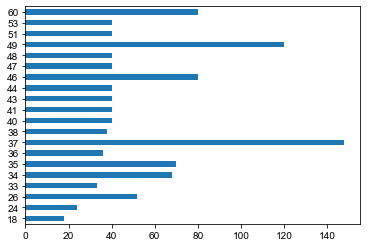

In [8]:
print('数据可视化：\n')
field = ['cjzongjia','cjzhouqi','danjia','cjtaoshu']
print('数据太多导致显示数据出现重叠看不清具体值，所以取前20个为例:')

for fie in field:
    print("{}前20个样例:".format(fie))
    data[fie].value_counts(sort=False).head(20).plot.barh()
    plt.show()

画出不同店家的成交数量饼图


<AxesSubplot:ylabel='mendian'>

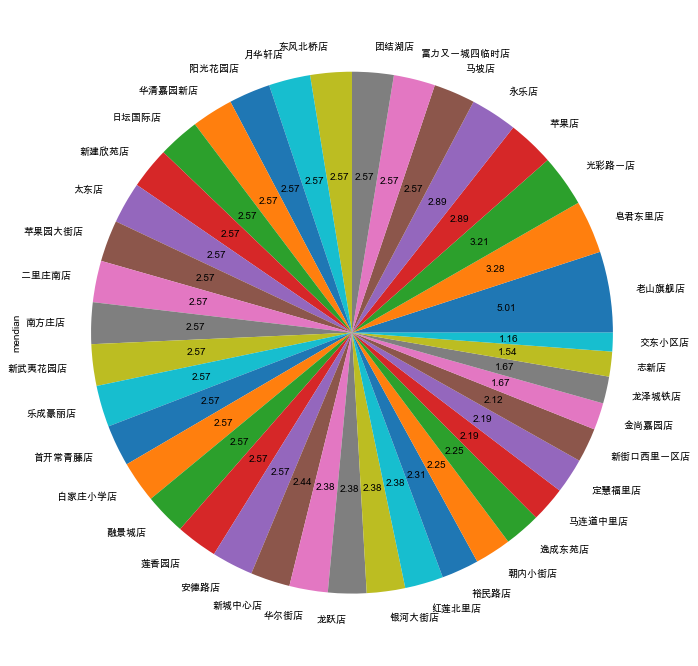

In [9]:
print("画出不同店家的成交数量饼图")
label=[]
for key in data['mendian'].value_counts().index:
    label.append(key)

data['mendian'].value_counts().plot.pie(labels=label, 
                 autopct='%.2f', fontsize=10,figsize=(12, 12))

画出不同从月年限的饼图


<AxesSubplot:ylabel='congyenianxian'>

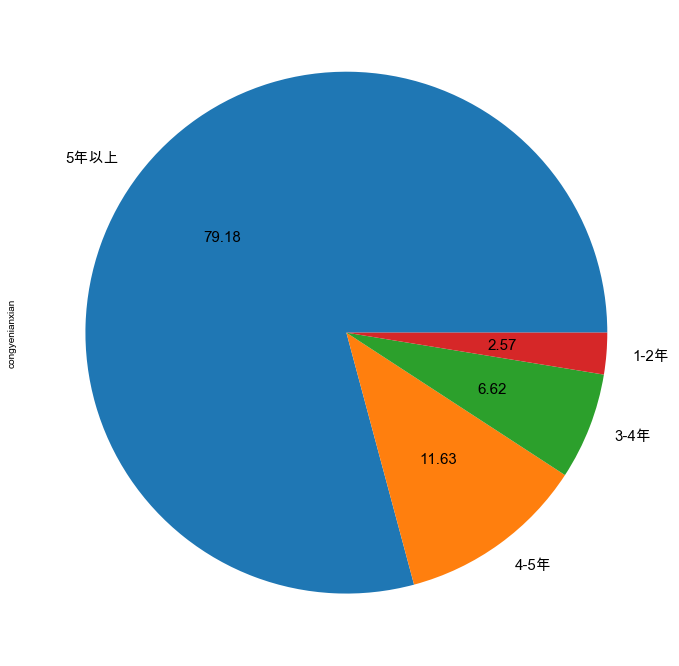

In [10]:
print("画出不同从月年限的饼图")
label=[]
for key in data['congyenianxian'].value_counts().index:
    label.append(key)

data['congyenianxian'].value_counts().plot.pie(labels=label, 
                 autopct='%.2f', fontsize=15,figsize=(12, 12))

画出不同板块（地区）的饼图


<AxesSubplot:ylabel='bankuai'>

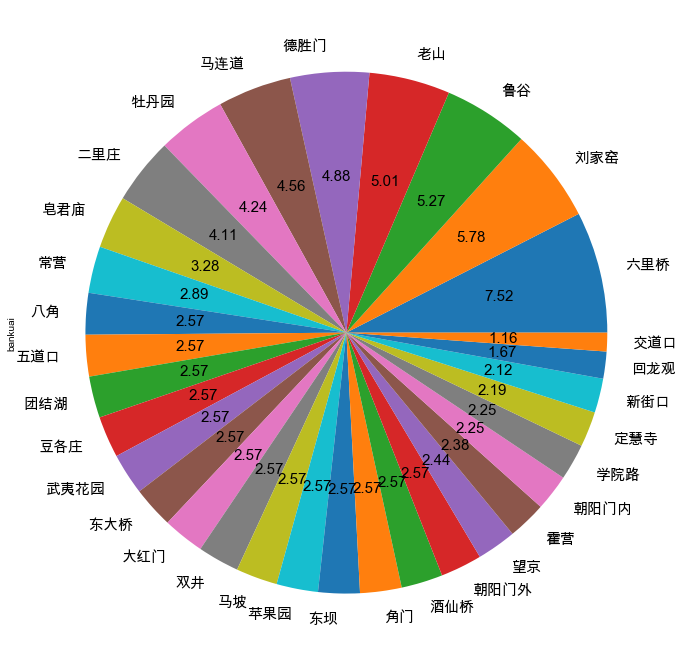

In [11]:
print("画出不同板块（地区）的饼图")
label=[]
for key in data['bankuai'].value_counts().index:
    label.append(key)

data['bankuai'].value_counts().plot.pie(labels=label, 
                 autopct='%.2f', fontsize=15,figsize=(12, 12))

画出不同标签的饼图


<AxesSubplot:ylabel='biaoqian'>

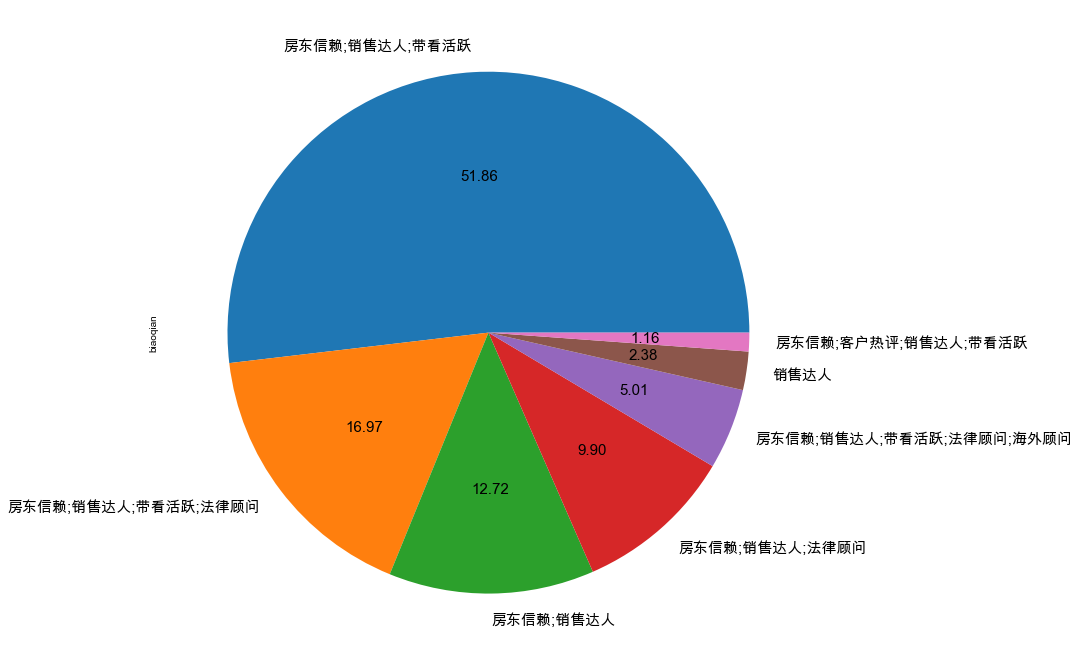

In [12]:
print("画出不同标签的饼图")
label=[]
for key in data['biaoqian'].value_counts().index:
    label.append(key)

data['biaoqian'].value_counts().plot.pie(labels=label, 
                 autopct='%.2f', fontsize=15,figsize=(12, 12))

## 2 房价预测-链家数据数据读取

In [13]:
# 查看数据
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
f=open(r'data/lianjia1.csv',encoding='gbk')
data=pd.read_csv(f)
#print(len(data)) 1536
data.head()

cjtaoshu mendian  cjzongjia zhiwei  haoping  cjdanjia         cjxiaoqu  \
0        37   红莲北里店      251.0    店经理  97% 141  43997元/平    红莲北里 3室1厅 57平   
1        37   红莲北里店      159.0    店经理  97% 141  36969元/平    红莲南里 1室1厅 43平   
2        37   红莲北里店      257.0    店经理  97% 141  39046元/平   常青藤嘉园 1室1厅 65平   
3        37   红莲北里店      243.0    店经理  97% 141  41313元/平    红莲北里 2室1厅 58平   
4        37   红莲北里店      372.5    店经理  97% 141  42053元/平  广安门外大街 3室1厅 88平   

  xingming  cjzhouqi        biaoqian        cjlouceng        cjshijian  \
0      郭海龙        36  房东信赖;销售达人;带看活跃       南 北/高楼层/6层  签约时间：2015-05-24   
1      郭海龙        36  房东信赖;销售达人;带看活跃         南/高楼层/7层  签约时间：2015-05-10   
2      郭海龙        36  房东信赖;销售达人;带看活跃        北/低楼层/16层  签约时间：2015-04-26   
3      郭海龙        36  房东信赖;销售达人;带看活跃       南 北/高楼层/6层  签约时间：2015-04-04   
4      郭海龙        36  房东信赖;销售达人;带看活跃  东 南 西 北/中楼层/18层  签约时间：2015-04-01   

  congyenianxian bankuai  
0           4-5年     马连道  
1           4-5年     马连道  
2           4-5年     马连道  
3           4-5年     马连道  
4           4-5年     马连道

In [14]:
# 拼接8个数据集
data_list=[]
for i in range(1,5):
    try:
        f=open(r'./data/lianjia{}.csv'.format(i),encoding='gbk')
        data=pd.read_csv(f)
    except:
        f=open(r'./data/lianjia{}.csv'.format(i),encoding='utf-8')
        data=pd.read_csv(f)
    data_list.append(data)
data = pd.concat(data_list)
print(len(data)) # 数据总量为162227
data.tail()

45703


cjtaoshu mendian  cjzongjia zhiwei haoping  cjdanjia          cjxiaoqu  \
13871        21  西红门地铁店      337.0    店经理  98% 83  30998元/平  兴海家园月苑 3室1厅 108平   
13872        21  西红门地铁店      182.5    店经理  98% 83  31315元/平   兴海家园月苑 1室1厅 58平   
13873        21  西红门地铁店      183.0    店经理  98% 83  29791元/平   兴海家园星苑 1室1厅 61平   
13874        21  西红门地铁店      260.0    店经理  98% 83  25642元/平    宏盛家园 2室2厅 101平   
13875        21  西红门地铁店      186.0    店经理  98% 83  30368元/平   兴海家园星苑 1室1厅 61平   

      xingming cjzhouqi biaoqian   cjlouceng        cjshijian congyenianxian  \
13871      申艳茹       40     销售达人  南 北/中楼层/6层  签约时间：2015-12-12           5年以上   
13872      申艳茹       40     销售达人    南/高楼层/6层  签约时间：2015-10-09           5年以上   
13873      申艳茹       40     销售达人  南 北/高楼层/6层  签约时间：2015-10-05           5年以上   
13874      申艳茹       40     销售达人  南 北/低楼层/6层  签约时间：2015-08-17           5年以上   
13875      申艳茹       40     销售达人  南 北/高楼层/6层  签约时间：2015-06-12           5年以上   

      bankuai  
13871     西红门  
13872     西红门  
13873     西红门  
13874     西红门  
13875     西红门

In [15]:
#查看数据描述
data.describe()

cjtaoshu     cjzongjia
count  45703.000000  45703.000000
mean      40.860206    328.063009
std       19.295455    212.151150
min        1.000000      0.000000
25%       28.000000    195.000000
50%       38.000000    275.000000
75%       48.000000    400.000000
max      161.000000   4450.000000

In [16]:
#查看数据描述
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45703 entries, 0 to 13875
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   cjtaoshu        45703 non-null  int64  
 1   mendian         45703 non-null  object 
 2   cjzongjia       45703 non-null  float64
 3   zhiwei          45703 non-null  object 
 4   haoping         45703 non-null  object 
 5   cjdanjia        45703 non-null  object 
 6   cjxiaoqu        45703 non-null  object 
 7   xingming        45703 non-null  object 
 8   cjzhouqi        45703 non-null  object 
 9   biaoqian        45703 non-null  object 
 10  cjlouceng       45703 non-null  object 
 11  cjshijian       45703 non-null  object 
 12  congyenianxian  45703 non-null  object 
 13  bankuai         45703 non-null  object 
dtypes: float64(1), int64(1), object(12)
memory usage: 5.2+ MB


### 1.1 抽取特征数据
我们总共选取了相关特征数据进行分析，其中包括了：成交套数、门店、成交总价、职位、成交小区、成交楼层、成交时间、板块等。

In [17]:
# 抽取特征数据进行分析
data=data[['cjtaoshu','mendian','cjzongjia','zhiwei','cjxiaoqu','cjlouceng','cjshijian','bankuai']]
data.head()

cjtaoshu mendian  cjzongjia zhiwei         cjxiaoqu        cjlouceng  \
0        37   红莲北里店      251.0    店经理    红莲北里 3室1厅 57平       南 北/高楼层/6层   
1        37   红莲北里店      159.0    店经理    红莲南里 1室1厅 43平         南/高楼层/7层   
2        37   红莲北里店      257.0    店经理   常青藤嘉园 1室1厅 65平        北/低楼层/16层   
3        37   红莲北里店      243.0    店经理    红莲北里 2室1厅 58平       南 北/高楼层/6层   
4        37   红莲北里店      372.5    店经理  广安门外大街 3室1厅 88平  东 南 西 北/中楼层/18层   

         cjshijian bankuai  
0  签约时间：2015-05-24     马连道  
1  签约时间：2015-05-10     马连道  
2  签约时间：2015-04-26     马连道  
3  签约时间：2015-04-04     马连道  
4  签约时间：2015-04-01     马连道

In [18]:
# 对汇总数据进行清洗
data.dropna(how='any')
data.drop_duplicates(keep='first', inplace=True)
# 删除其中总价有异常的数据
data = data.loc[data['cjzongjia']>50.0]
print("处理后数据集大小：",len(data))

处理后数据集大小： 44331


In [19]:
# 处理特征mendian
mendian_map = data['mendian'].unique()
mendian_dict = {}
for i in range(0, len(mendian_map)):
    x = {mendian_map[i]:int(i+1)}
    mendian_dict.update(x)
data['mendian'] = data['mendian'].map(mendian_dict)
data.head()

cjtaoshu  mendian  cjzongjia zhiwei         cjxiaoqu        cjlouceng  \
0        37        1      251.0    店经理    红莲北里 3室1厅 57平       南 北/高楼层/6层   
1        37        1      159.0    店经理    红莲南里 1室1厅 43平         南/高楼层/7层   
2        37        1      257.0    店经理   常青藤嘉园 1室1厅 65平        北/低楼层/16层   
3        37        1      243.0    店经理    红莲北里 2室1厅 58平       南 北/高楼层/6层   
4        37        1      372.5    店经理  广安门外大街 3室1厅 88平  东 南 西 北/中楼层/18层   

         cjshijian bankuai  
0  签约时间：2015-05-24     马连道  
1  签约时间：2015-05-10     马连道  
2  签约时间：2015-04-26     马连道  
3  签约时间：2015-04-04     马连道  
4  签约时间：2015-04-01     马连道

In [20]:
# 处理特征zhiwei
zhiwei_map = data['zhiwei'].unique()
zhiwei_dict = {}
for i in range(0, len(zhiwei_map)):
    x = {zhiwei_map[i]:int(i+1)}
    zhiwei_dict.update(x)
data['zhiwei'] = data['zhiwei'].map(zhiwei_dict)
data.head()

cjtaoshu  mendian  cjzongjia  zhiwei         cjxiaoqu        cjlouceng  \
0        37        1      251.0       1    红莲北里 3室1厅 57平       南 北/高楼层/6层   
1        37        1      159.0       1    红莲南里 1室1厅 43平         南/高楼层/7层   
2        37        1      257.0       1   常青藤嘉园 1室1厅 65平        北/低楼层/16层   
3        37        1      243.0       1    红莲北里 2室1厅 58平       南 北/高楼层/6层   
4        37        1      372.5       1  广安门外大街 3室1厅 88平  东 南 西 北/中楼层/18层   

         cjshijian bankuai  
0  签约时间：2015-05-24     马连道  
1  签约时间：2015-05-10     马连道  
2  签约时间：2015-04-26     马连道  
3  签约时间：2015-04-04     马连道  
4  签约时间：2015-04-01     马连道

In [21]:
# 处理特征bankuai
bankuai_map = data['bankuai'].unique()
bankuai_dict = {}
for i in range(0, len(bankuai_map)):
    x = {bankuai_map[i]:int(i+1)}
    bankuai_dict.update(x)
data['bankuai'] = data['bankuai'].map(bankuai_dict)
data.head()

cjtaoshu  mendian  cjzongjia  zhiwei         cjxiaoqu        cjlouceng  \
0        37        1      251.0       1    红莲北里 3室1厅 57平       南 北/高楼层/6层   
1        37        1      159.0       1    红莲南里 1室1厅 43平         南/高楼层/7层   
2        37        1      257.0       1   常青藤嘉园 1室1厅 65平        北/低楼层/16层   
3        37        1      243.0       1    红莲北里 2室1厅 58平       南 北/高楼层/6层   
4        37        1      372.5       1  广安门外大街 3室1厅 88平  东 南 西 北/中楼层/18层   

         cjshijian  bankuai  
0  签约时间：2015-05-24        1  
1  签约时间：2015-05-10        1  
2  签约时间：2015-04-26        1  
3  签约时间：2015-04-04        1  
4  签约时间：2015-04-01        1

In [22]:
# 处理特征cjxiaoqu:分成三个特征：xiaoqu，buju，daxiao
# 首先处理特征小区:xiaoqu
data['xiaoqu'] = data.cjxiaoqu.map(lambda x:x.split(' ')[0])
xiaoqu_map = data['xiaoqu'].unique()
xiaoqu_dict = {}
for i in range(0, len(xiaoqu_map)):
    x = {xiaoqu_map[i]:int(i+1)}
    xiaoqu_dict.update(x)
data['xiaoqu'] = data['xiaoqu'].map(xiaoqu_dict)
data

cjtaoshu  mendian  cjzongjia  zhiwei          cjxiaoqu  \
0            37        1      251.0       1     红莲北里 3室1厅 57平   
1            37        1      159.0       1     红莲南里 1室1厅 43平   
2            37        1      257.0       1    常青藤嘉园 1室1厅 65平   
3            37        1      243.0       1     红莲北里 2室1厅 58平   
4            37        1      372.5       1   广安门外大街 3室1厅 88平   
...         ...      ...        ...     ...               ...   
13871        21      710      337.0       1  兴海家园月苑 3室1厅 108平   
13872        21      710      182.5       1   兴海家园月苑 1室1厅 58平   
13873        21      710      183.0       1   兴海家园星苑 1室1厅 61平   
13874        21      710      260.0       1    宏盛家园 2室2厅 101平   
13875        21      710      186.0       1   兴海家园星苑 1室1厅 61平   

             cjlouceng        cjshijian  bankuai  xiaoqu  
0           南 北/高楼层/6层  签约时间：2015-05-24        1       1  
1             南/高楼层/7层  签约时间：2015-05-10        1       2  
2            北/低楼层/16层  签约时间：2015-04-26        1       3  
3           南 北/高楼层/6层  签约时间：2015-04-04        1       1  
4      东 南 西 北/中楼层/18层  签约时间：2015-04-01        1       4  
...                ...              ...      ...     ...  
13871       南 北/中楼层/6层  签约时间：2015-12-12       71    1211  
13872         南/高楼层/6层  签约时间：2015-10-09       71    1211  
13873       南 北/高楼层/6层  签约时间：2015-10-05       71    1288  
13874       南 北/低楼层/6层  签约时间：2015-08-17       71    1210  
13875       南 北/高楼层/6层  签约时间：2015-06-12       71    1288  

[44331 rows x 9 columns]

In [23]:
# 处理特征房间布局：buju
data['buju'] = data.cjxiaoqu.map(lambda x:x.split(' ')[1])
buju_map = data['buju'].unique()
buju_dict = {}
for i in range(0, len(buju_map)):
    x = {buju_map[i]:int(i+1)}
    buju_dict.update(x)
data['buju'] = data['buju'].map(buju_dict)
data

cjtaoshu  mendian  cjzongjia  zhiwei          cjxiaoqu  \
0            37        1      251.0       1     红莲北里 3室1厅 57平   
1            37        1      159.0       1     红莲南里 1室1厅 43平   
2            37        1      257.0       1    常青藤嘉园 1室1厅 65平   
3            37        1      243.0       1     红莲北里 2室1厅 58平   
4            37        1      372.5       1   广安门外大街 3室1厅 88平   
...         ...      ...        ...     ...               ...   
13871        21      710      337.0       1  兴海家园月苑 3室1厅 108平   
13872        21      710      182.5       1   兴海家园月苑 1室1厅 58平   
13873        21      710      183.0       1   兴海家园星苑 1室1厅 61平   
13874        21      710      260.0       1    宏盛家园 2室2厅 101平   
13875        21      710      186.0       1   兴海家园星苑 1室1厅 61平   

             cjlouceng        cjshijian  bankuai  xiaoqu  buju  
0           南 北/高楼层/6层  签约时间：2015-05-24        1       1     1  
1             南/高楼层/7层  签约时间：2015-05-10        1       2     2  
2            北/低楼层/16层  签约时间：2015-04-26        1       3     2  
3           南 北/高楼层/6层  签约时间：2015-04-04        1       1     3  
4      东 南 西 北/中楼层/18层  签约时间：2015-04-01        1       4     1  
...                ...              ...      ...     ...   ...  
13871       南 北/中楼层/6层  签约时间：2015-12-12       71    1211     1  
13872         南/高楼层/6层  签约时间：2015-10-09       71    1211     2  
13873       南 北/高楼层/6层  签约时间：2015-10-05       71    1288     2  
13874       南 北/低楼层/6层  签约时间：2015-08-17       71    1210     5  
13875       南 北/高楼层/6层  签约时间：2015-06-12       71    1288     2  

[44331 rows x 10 columns]

In [24]:
# 处理特征房间大小：daxiao
data['daxiao'] = data.cjxiaoqu.map(lambda x:x.split(' ')[2])
data['daxiao'] = data['daxiao'].map(lambda x:x.replace('平',''))
data['daxiao'] = data['daxiao'].map(lambda x:int(x))
# 有标注错误的数据因此需要删掉大小异常的数据
# data['daxiao'].unique()
# data[data['daxiao']>400]
data = data.loc[data['daxiao']<1000]
data['daxiao'].unique()
data = data.drop('cjxiaoqu',axis=1)

In [25]:
data.head()

cjtaoshu  mendian  cjzongjia  zhiwei        cjlouceng        cjshijian  \
0        37        1      251.0       1       南 北/高楼层/6层  签约时间：2015-05-24   
1        37        1      159.0       1         南/高楼层/7层  签约时间：2015-05-10   
2        37        1      257.0       1        北/低楼层/16层  签约时间：2015-04-26   
3        37        1      243.0       1       南 北/高楼层/6层  签约时间：2015-04-04   
4        37        1      372.5       1  东 南 西 北/中楼层/18层  签约时间：2015-04-01   

   bankuai  xiaoqu  buju  daxiao  
0        1       1     1      57  
1        1       2     2      43  
2        1       3     2      65  
3        1       1     3      58  
4        1       4     1      88

In [26]:
# 处理特征:cjshijian
data['cjshijian'] = data.cjshijian.map(lambda x:x.split('：')[1])
data['cjshijian'] = data['cjshijian'].map(lambda x:x.split('-')[0])
data['cjshijian'] = data['cjshijian'].map(lambda x:int(x))
# data[data['daxiao']>400]
data['cjshijian'].unique()

array([2015, 2013, 2012, 2016, 2014, 2011, 2002])

In [27]:
data.head()

cjtaoshu  mendian  cjzongjia  zhiwei        cjlouceng  cjshijian  bankuai  \
0        37        1      251.0       1       南 北/高楼层/6层       2015        1   
1        37        1      159.0       1         南/高楼层/7层       2015        1   
2        37        1      257.0       1        北/低楼层/16层       2015        1   
3        37        1      243.0       1       南 北/高楼层/6层       2015        1   
4        37        1      372.5       1  东 南 西 北/中楼层/18层       2015        1   

   xiaoqu  buju  daxiao  
0       1     1      57  
1       2     2      43  
2       3     2      65  
3       1     3      58  
4       4     1      88

In [28]:
# 处理特征:cjlouceng，首先处理特征方向:fangxiang
data['fangxiang'] = data.cjlouceng.map(lambda x:x.split('/')[0])
fangxiang_map = data['fangxiang'].unique()
fangxiang_dict = {}
for i in range(0, len(fangxiang_map)):
    x = {fangxiang_map[i]:int(i+1)}
    fangxiang_dict.update(x)
data['fangxiang'] = data['fangxiang'].map(fangxiang_dict)
data


cjtaoshu  mendian  cjzongjia  zhiwei        cjlouceng  cjshijian  \
0            37        1      251.0       1       南 北/高楼层/6层       2015   
1            37        1      159.0       1         南/高楼层/7层       2015   
2            37        1      257.0       1        北/低楼层/16层       2015   
3            37        1      243.0       1       南 北/高楼层/6层       2015   
4            37        1      372.5       1  东 南 西 北/中楼层/18层       2015   
...         ...      ...        ...     ...              ...        ...   
13871        21      710      337.0       1       南 北/中楼层/6层       2015   
13872        21      710      182.5       1         南/高楼层/6层       2015   
13873        21      710      183.0       1       南 北/高楼层/6层       2015   
13874        21      710      260.0       1       南 北/低楼层/6层       2015   
13875        21      710      186.0       1       南 北/高楼层/6层       2015   

       bankuai  xiaoqu  buju  daxiao  fangxiang  
0            1       1     1      57          1  
1            1       2     2      43          2  
2            1       3     2      65          3  
3            1       1     3      58          1  
4            1       4     1      88          4  
...        ...     ...   ...     ...        ...  
13871       71    1211     1     108          1  
13872       71    1211     2      58          2  
13873       71    1288     2      61          1  
13874       71    1210     5     101          1  
13875       71    1288     2      61          1  

[44318 rows x 11 columns]

In [29]:
# 处理特征:cjlouceng，处理特征高低楼层:gaodi
data['gaodi'] = data.cjlouceng.map(lambda x:x.split('/')[1])
gaodi_map = data['gaodi'].unique()
gaodi_dict = {}
for i in range(0, len(gaodi_map)):
    x = {gaodi_map[i]:int(i+1)}
    gaodi_dict.update(x)
data['gaodi'] = data['gaodi'].map(gaodi_dict)
data

cjtaoshu  mendian  cjzongjia  zhiwei        cjlouceng  cjshijian  \
0            37        1      251.0       1       南 北/高楼层/6层       2015   
1            37        1      159.0       1         南/高楼层/7层       2015   
2            37        1      257.0       1        北/低楼层/16层       2015   
3            37        1      243.0       1       南 北/高楼层/6层       2015   
4            37        1      372.5       1  东 南 西 北/中楼层/18层       2015   
...         ...      ...        ...     ...              ...        ...   
13871        21      710      337.0       1       南 北/中楼层/6层       2015   
13872        21      710      182.5       1         南/高楼层/6层       2015   
13873        21      710      183.0       1       南 北/高楼层/6层       2015   
13874        21      710      260.0       1       南 北/低楼层/6层       2015   
13875        21      710      186.0       1       南 北/高楼层/6层       2015   

       bankuai  xiaoqu  buju  daxiao  fangxiang  gaodi  
0            1       1     1      57          1      1  
1            1       2     2      43          2      1  
2            1       3     2      65          3      2  
3            1       1     3      58          1      1  
4            1       4     1      88          4      3  
...        ...     ...   ...     ...        ...    ...  
13871       71    1211     1     108          1      3  
13872       71    1211     2      58          2      1  
13873       71    1288     2      61          1      1  
13874       71    1210     5     101          1      2  
13875       71    1288     2      61          1      1  

[44318 rows x 12 columns]

In [30]:
# 处理特征:cjlouceng，处理特征楼层数:cengshu
data['cengshu'] = data.cjlouceng.map(lambda x:x.split('/')[2])
data['cengshu'] = data['cengshu'].map(lambda x:x.replace('层',''))
data = data.loc[data['cengshu']!='']
data = data.loc[data['cengshu']!='0']
data['cengshu'] = data['cengshu'].map(lambda x:int(x))
data['cengshu'].unique()
data = data.drop('cjlouceng', axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44300 entries, 0 to 13875
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   cjtaoshu   44300 non-null  int64  
 1   mendian    44300 non-null  int64  
 2   cjzongjia  44300 non-null  float64
 3   zhiwei     44300 non-null  int64  
 4   cjshijian  44300 non-null  int64  
 5   bankuai    44300 non-null  int64  
 6   xiaoqu     44300 non-null  int64  
 7   buju       44300 non-null  int64  
 8   daxiao     44300 non-null  int64  
 9   fangxiang  44300 non-null  int64  
 10  gaodi      44300 non-null  int64  
 11  cengshu    44300 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 4.4 MB


In [31]:
data

cjtaoshu  mendian  cjzongjia  zhiwei  cjshijian  bankuai  xiaoqu  buju  \
0            37        1      251.0       1       2015        1       1     1   
1            37        1      159.0       1       2015        1       2     2   
2            37        1      257.0       1       2015        1       3     2   
3            37        1      243.0       1       2015        1       1     3   
4            37        1      372.5       1       2015        1       4     1   
...         ...      ...        ...     ...        ...      ...     ...   ...   
13871        21      710      337.0       1       2015       71    1211     1   
13872        21      710      182.5       1       2015       71    1211     2   
13873        21      710      183.0       1       2015       71    1288     2   
13874        21      710      260.0       1       2015       71    1210     5   
13875        21      710      186.0       1       2015       71    1288     2   

       daxiao  fangxiang  gaodi  cengshu  
0          57          1      1        6  
1          43          2      1        7  
2          65          3      2       16  
3          58          1      1        6  
4          88          4      3       18  
...       ...        ...    ...      ...  
13871     108          1      3        6  
13872      58          2      1        6  
13873      61          1      1        6  
13874     101          1      2        6  
13875      61          1      1        6  

[44300 rows x 12 columns]

## 3 预测房价

In [32]:
# 分配数据集-训练集和测试集
prices = data['cjzongjia']
features = data.drop('cjzongjia', axis = 1)
print('北京二手房房价有数据 {0} 条，字段 {1} 个。'.format(*data.shape))
data.head()

北京二手房房价有数据 44300 条，字段 12 个。


cjtaoshu  mendian  cjzongjia  zhiwei  cjshijian  bankuai  xiaoqu  buju  \
0        37        1      251.0       1       2015        1       1     1   
1        37        1      159.0       1       2015        1       2     2   
2        37        1      257.0       1       2015        1       3     2   
3        37        1      243.0       1       2015        1       1     3   
4        37        1      372.5       1       2015        1       4     1   

   daxiao  fangxiang  gaodi  cengshu  
0      57          1      1        6  
1      43          2      1        7  
2      65          3      2       16  
3      58          1      1        6  
4      88          4      3       18

In [33]:
import numpy as np

# 转换训练测试集格式为数组
features = np.array(features)
prices = np.array(prices)
# 查看数据
print(features[3])
print(prices[3])

# 导入sklearn进行训练测试集划分
from sklearn.model_selection import train_test_split
features_train, features_test, prices_train, prices_test = train_test_split(features, prices, test_size=0.2, random_state=0)

[  37    1    1 2015    1    1    3   58    1    1    6]
243.0


### 3.1 线性回归方法
使用简易的线性回归方法，对房价进行回归预测


In [34]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math

In [35]:
#模型可视化，用于评估预测价格与真实价格之间的误差，黄色点越接近绿色直线，说明预测价格更接近真实价格 
def show(price_test,predict_price):
    plt.plot(price_test, predict_price, color='y', marker='o')
    plt.plot(price_test, price_test,color='g', marker='+')
    plt.show()


In [36]:
# 使用 sklern 中的线性回归模型进行拟合，所使用数据为之前划分的数据 feature、price
clf = linear_model.LinearRegression()
clf.fit(features,prices)

LinearRegression()

In [37]:
w = clf.coef_
print("w = ",w)
b = clf.intercept_  #线性回归模型计算截距值
print("b = ",b)

R_Square = clf.score(features,prices)  #判定系数R-Square,即描述模型和数据的拟合程度
print(R_Square)

w =  [-1.57993896e+00 -6.87545894e-02 -8.31478115e+00  3.89085855e+01
  8.38693031e-02  7.33918409e-03 -9.85118580e-01  3.23872866e+00
  1.12633303e+00  4.06701668e+00  7.56186364e-01]
b =  -78263.48036715187
0.5004716554700971


In [38]:
#使用features测试price，这里只列举了一个样本的特征进行价格的预测

a=[[37, 1, 1, 2015, 1, 1, 3, 58, 1, 1, 6]]
price_a=243
predict_a = clf.predict(a)
print("predict_a=",predict_a)


predict_a= [265.19080655]


可以看到，我们使用数据集中数据进行测试，可以看到，真实结果为243，我们使用线性回归进行预测的结果为253.43

[203.97985811 893.30446704 260.77753736 ...  60.80745876 560.50057533
 209.65355033]
error= 0.31178571382604403


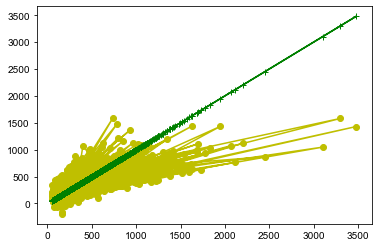

In [39]:
#使用测试集评估模型,首先输入测试集features，得到预测的price
#print(price_test)
predict_price = clf.predict(features_test)
list(predict_price)  #预测价格生成列表
print(predict_price)

error_sum =sum(np.sqrt((prices_test-predict_price)**2)) #求解预测price与真实price之间的误差总和
price_test_sum =sum(prices_test)
error =error_sum/price_test_sum  #评估模型的准确度
print("error=",error)
show(prices_test,predict_price)

In [40]:
# 使用平均绝对误差（MAE）、均方误差（MSE）、均方根误差（RMSE）等方法进行测试
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

print('MAE = ', mean_absolute_error(prices_test,predict_price))
print('MSE = ', mean_squared_error(prices_test,predict_price))
print('RMSE = ', math.sqrt(mean_squared_error(prices_test,predict_price)))

MAE =  102.72360890517187
MSE =  21969.602742764044
RMSE =  148.22146518896662


### 3.2 决策树回归方法
建立决策树回归模型，通过GridSearchCV找到最优深度参数。

In [41]:
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

# 利用GridSearchCV计算最优解
def fit_model(X, y):
    """ 基于输入数据 [X,y]，利于网格搜索找到最优的决策树模型"""
    
    cross_validator = KFold(10, shuffle=True)
      
    regressor = DecisionTreeRegressor()
    
    params = {'max_depth':[1,2,3,4,5,6,7,8,9,10]}
    
    scoring_fnc = make_scorer(performance_metric)
    
    grid = GridSearchCV(estimator = regressor, param_grid = params, scoring = scoring_fnc, cv = cross_validator)

    # 基于输入数据 [X,y]，进行网格搜索
    grid = grid.fit(X, y)
#     print pd.DataFrame(grid.cv_results_)
    return grid.best_estimator_

# 计算R2分数
def performance_metric(y_true, y_predict):
    """计算并返回预测值相比于预测值的分数"""
    from sklearn.metrics import r2_score
    score = r2_score(y_true, y_predict)

    return score

In [42]:

optimal_reg1 = fit_model(features_train, prices_train)

# 输出最优模型的 'max_depth' 参数
print("最理想模型的参数 'max_depth' 是 {} 。".format(optimal_reg1.get_params()['max_depth']))

predicted_value = optimal_reg1.predict(features_test)
r2 = performance_metric(prices_test, predicted_value)

print("最优模型在测试数据上 R^2 分数 {:,.2f}。".format(r2))

最理想模型的参数 'max_depth' 是 8 。
最优模型在测试数据上 R^2 分数 0.54。


error= 0.28401893251130395


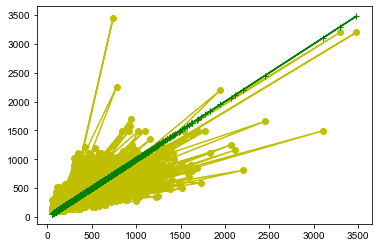

In [43]:
error_sum =sum(np.sqrt((prices_test-predicted_value)**2)) #求解预测price与真实price之间的误差总和
price_test_sum =sum(prices_test)
error =error_sum/price_test_sum  #评估模型的准确度
print("error=",error)
show(prices_test,predicted_value)

In [44]:
# 使用平均绝对误差（MAE）、均方误差（MSE）、均方根误差（RMSE）等方法进行测试
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

print('MAE = ', mean_absolute_error(prices_test,predicted_value))
print('MSE = ', mean_squared_error(prices_test,predicted_value))
print('RMSE = ', math.sqrt(mean_squared_error(prices_test,predicted_value)))

MAE =  93.57532578042853
MSE =  19791.580476362407
RMSE =  140.6825521390709
